# Workflows in the Uncertainty Engine SDK

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/digiLab-ai/ue-sdk-helper/blob/main/notebooks/01_workflow.ipynb)

In this notebook, we go through how to setup a workflow in the SDK.

## 1. Setup

We start by installing the Uncertainty Engine:

In [ ]:
!pip install --quiet uncertainty-engine[vis,notebook]

And then make our imports:

In [ ]:
from uncertainty_engine import Client
import os

We have different methods for interacting with our Uncertainty Engine username and password depending on whether you are using Google Colab or a local python install.

Please update the following accordingly:

In [ ]:
is_google_colab = True
is_local = not is_google_colab

### Option A: Google Colab

On the left, click on the key (<img src= width="20"/>). Select `+ Add new secret`.

Then, fill in:

*   ```UE_USERNAME```: your Uncertainty Engine username (email address),
*   ```UE_PASSWORD```: your Uncertainty Engine password,
*   ```UE_ACCOUNT_ID```: your 16 digit id.

It should look like:

<img src= width="500"/>

In [ ]:
if is_google_colab:
    from google.colab import userdata

    os.environ["UE_PASSWORD"] = userdata.get("UE_PASSWORD")
    os.environ["UE_USERNAME"] = userdata.get("UE_USERNAME")
    os.environ["UE_ACCOUNT_ID"] = userdata.get("UE_ACCOUNT_ID")


### Option B: Local Use

Run the following in your terminal:

On mac / linux:

```
export UE_USERNAME="your_username"
export UE_PASSWORD="your_password"
export UE_ACCOUNT_ID="your_16_digit_id"
```

On windows:

```
set UE_USERNAME="your_username"
set UE_PASSWORD="your_password"
set UE_ACCOUNT_ID="your_16_digit_id"
```



### Initialise your Uncertainty Engine client.

In [ ]:
client = Client()

In [ ]:
client.authenticate(os.environ["UE_ACCOUNT_ID"])


/tmp/ipython-input-2640184759.py:1: DeprecationWarning: The 'account_id' parameter is deprecated and will be removed in the next release. Fetching account ID from HTTP headers instead.
  client.authenticate(os.environ["UE_ACCOUNT_ID"])


## 2. Making a Workflow

### 2.a. Viewing the nodes

Once you have initialised the Uncertainty Engine client you can use the `list_nodes` method to find your node information. Fields such as the `description`, `inputs` and `outputs` are particularly useful for building your workflow.

In [ ]:
from pprint import pprint

# Create a dictionary with node IDs as keys
nodes = client.list_nodes()
nodes_by_id = {node["id"]: node for node in nodes}

# Print the details of the `Add` node
pprint(nodes_by_id["Add"])

SSLError: HTTPSConnectionPool(host='de1v75vvk6.execute-api.eu-west-2.amazonaws.com', port=443): Max retries exceeded with url: /nodes/list (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)')))

### 2.b. Constructing a graph

Next import and initialise the `Graph` object.

In [ ]:
from uncertainty_engine.graph import Graph

graph = Graph()

This `Graph` object allows you to connect sets of nodes together. Which, along with the definition of any inputs external to the graph, can be executed as a workflow.  

Next we can define our starting node. We will use `Add` nodes throughout this example as they're the simplest to understand.

In [ ]:
from uncertainty_engine.nodes.basic import Add

add_1 = Add(
  rhs=1,
  lhs=2,
  label="First Add"
)

We now want to add it to our `graph`.

In [ ]:
graph.add_node(add_1)

We can define the output handle of the `add_1` node so that we can use it as an input for another node.

In [ ]:
ans_1 = add_1.make_handle("ans")

Now lets add an additional `Add` node but make one its inputs the result of the first addition. To do this we will create another instance of the `Add` class where its `rhs` input is defined as `and_1`.

In [ ]:
add_2 = Add(
  rhs=ans_1,
  lhs=3,
  label="Second Add"
)

graph.add_node(add_2)

Before executing the workflow we can visualize the graph we have created.

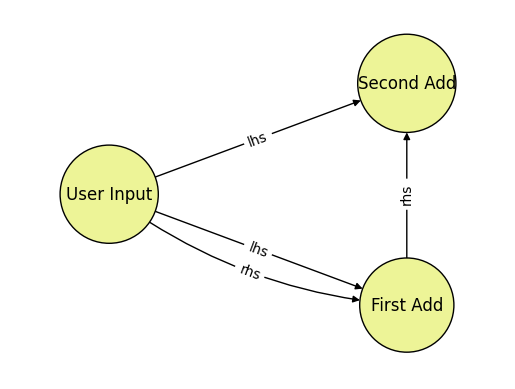

In [ ]:
from uncertainty_engine.visualization import visualize_graph

visualize_graph(graph)

We can also perform the visualisation via the print method:

In [ ]:
pprint(graph.nodes)

{'nodes': {'First Add': {'inputs': {'lhs': {'node_handle': 'First Add_lhs',
                                            'node_name': '_'},
                                    'rhs': {'node_handle': 'First Add_rhs',
                                            'node_name': '_'}},
                         'type': 'Add'},
           'Second Add': {'inputs': {'lhs': {'node_handle': 'Second Add_lhs',
                                             'node_name': '_'},
                                     'rhs': {'node_handle': 'ans',
                                             'node_name': 'First Add'}},
                          'type': 'Add'}}}


We can see in tha above visualization that the external inputs to the graph appear as their own "node" with label "User Input". We can also see that all connections between nodes are labelled with the input variable of the target node. These visualizations can be useful to understand the graphs you're constructing as they grow in complexity.

For example, we can add a final `Add` node, connected to our other `Add` nodes, and visually confirm it has been added to the graph as expected.

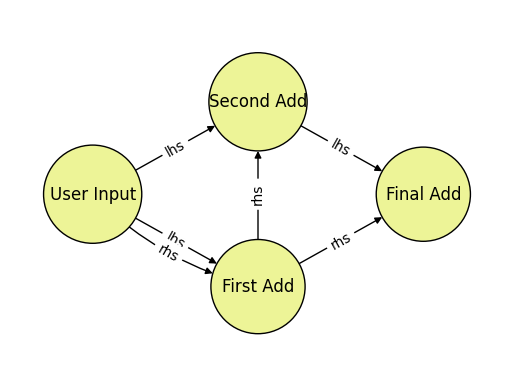

In [ ]:
ans_2 = add_2.make_handle("ans")

add_3 = Add(
  rhs=ans_1,
  lhs=ans_2,
  label="Final Add"
)

graph.add_node(add_3)

visualize_graph(graph)

In [ ]:
pprint(graph.nodes)

{'nodes': {'Final Add': {'inputs': {'lhs': {'node_handle': 'ans',
                                            'node_name': 'Second Add'},
                                    'rhs': {'node_handle': 'ans',
                                            'node_name': 'First Add'}},
                         'type': 'Add'},
           'First Add': {'inputs': {'lhs': {'node_handle': 'First Add_lhs',
                                            'node_name': '_'},
                                    'rhs': {'node_handle': 'First Add_rhs',
                                            'node_name': '_'}},
                         'type': 'Add'},
           'Second Add': {'inputs': {'lhs': {'node_handle': 'Second Add_lhs',
                                             'node_name': '_'},
                                     'rhs': {'node_handle': 'ans',
                                             'node_name': 'First Add'}},
                          'type': 'Add'}}}


## 2.c. Executing a workflow

In the Uncertainty Engine, workflows are treated like any other node. This allows you to construct workflows and then use them like nodes in new workflows. So to execute our graph in a workflow we first import and initialise the `Workflow` node.

In [ ]:
from uncertainty_engine.nodes.workflow import Workflow

# Define our final add output handle
ans_3 = add_3.make_handle("ans")

workflow = Workflow(
    graph=graph.nodes,
    input=graph.external_input,
    external_input_id=graph.external_input_id,
    requested_output={
        "First Add": ans_1.model_dump(), # use model_dump to make the output serialisable
        "Second Add": ans_2.model_dump(),
        "Final Add": ans_3.model_dump(),
        }
    )

In the above cell we have defined our `requested_output` as the output of all of our addition nodes. However, if you don't have to request the result from all of your nodes. This can be very useful when debugging complex or costly workflows.

Now execute the workflow like any other node.

In [ ]:
response = client.run_node(workflow)
pprint(response.model_dump())

{'inputs': {'external_input_id': '_',
            'graph': {'nodes': {'Final Add': {'inputs': {'lhs': {'node_handle': 'ans',
                                                                 'node_name': 'Second '
                                                                              'Add'},
                                                         'rhs': {'node_handle': 'ans',
                                                                 'node_name': 'First '
                                                                              'Add'}},
                                              'type': 'Add'},
                                'First Add': {'inputs': {'lhs': {'node_handle': 'First '
                                                                                'Add_lhs',
                                                                 'node_name': '_'},
                                                         'rhs': {'node_handle': 'First '
                         

To retrieve results, we can look at the outputs:

In [ ]:
pprint(response.model_dump()['outputs'])

{'outputs': {'Final Add': 9.0, 'First Add': 3.0, 'Second Add': 6.0}}


Success? Any problems, contact [dan.greenhouse@digilab.ai](dan.greenhouse@digilab.ai) or submit a ticket at the Help Center: [get.support.uncertaintyengine.ai](get.support.uncertaintyengine.ai).